In [16]:
import pandas as pd
import re
import numpy as np
import statsmodels.formula.api as smf
path_dist   = r"../data/input/abortion_distance_raw.csv"
path_births = r"../data/input/oklahoma_births-by-county_by-race_2010-2024.csv"

dist_raw   = pd.read_csv(path_dist)
births_raw = pd.read_csv(path_births)


In [17]:
births_raw.head(30)

,Search Characteristic,Values Selected,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Year 2010,NaN,NaN,NaN,NaN
1,NaN,NaN,Births,Population,Birth Rate
2,County of Residence,Mother's Race,NaN,NaN,NaN
3,UNKNOWN,White,18,.,.
4,NaN,Black or African American,.,.,.
5,NaN,American Indian or Alaska Native,.,.,.
6,NaN,Unknown,.,.,.
7,Adair,White,63,10038,6.3
8,NaN,Black or African American,.,69,.
9,NaN,American Indian or Alaska Native,169,10210,16.6


In [18]:
dist = dist_raw.copy()
# Option A: use the state column
ok = dist[dist["origin_state"] == "OK"].copy()
ok["county"] = (
    ok["origin_county_name"]
        .str.replace(r"\s*\(.*\)", "", regex=True)
        .str.replace(" County", "", regex=False)    
        .str.strip()
)
dist_df = ok[['year','month',"origin_fips_code", "county", "origin_state", "origin_population", 'distance_origintodest']]

dist_df

,year,month,origin_fips_code,county,origin_state,origin_population,distance_origintodest
426200,2010,8,40001,Adair,OK,4285.0,44.282017
426201,2010,9,40001,Adair,OK,4285.0,44.282017
426202,2010,10,40001,Adair,OK,4285.0,44.282017
426203,2010,11,40001,Adair,OK,4285.0,44.282017
426204,2010,12,40001,Adair,OK,4285.0,44.282017
...,...,...,...,...,...,...,...
441595,2018,1,40153,Woodward,OK,3669.0,141.880800
441596,2018,2,40153,Woodward,OK,3669.0,141.880800
441597,2018,3,40153,Woodward,OK,3669.0,141.880800
441598,2018,4,40153,Woodward,OK,3669.0,141.880800


In [19]:
import pandas as pd
import numpy as np

df = births_raw.copy()
df.columns = ["col0", "col1", "col2", "col3", "col4"]
is_year_row = df["col0"].astype(str).str.contains("Year", na=False)

df.loc[is_year_row, "year"] = (
    df.loc[is_year_row, "col0"]
      .astype(str)
      .str.extract(r"(\d{4})")[0]
      .astype("Int64")
)
df["year"] = df["year"].ffill()
df = df[df["year"].notna()].copy()
df = df[~df["col1"].eq("Mother's Race")].copy()
df = df[~is_year_row].copy()

df["county"] = df["col0"].where(df["col0"].notna()).ffill()

county_filter = (
    df["county"].fillna("").str.fullmatch("Unknown", case=False) |
    df["county"].fillna("").str.contains("UNKNOWN COUNTY", case=False)
)
df = df[~county_filter].copy()
df["race"] = df["col1"]

for c in ["col2", "col3", "col4"]:
    df[c] = pd.to_numeric(df[c].replace(".", np.nan), errors="coerce")

df = df.rename(columns={
    "col2": "births",
    "col3": "population",
    "col4": "birth_rate",
})
valid = df["births"].notna() | df["population"].notna()
df = df[valid].copy()

df.loc[df["births"].isna() & df["population"].notna(), "births"] = 0

needs_rate = df["birth_rate"].isna() & df["population"].gt(0)
df.loc[needs_rate, "birth_rate"] = (
    df.loc[needs_rate, "births"] / df.loc[needs_rate, "population"] * 1000
)
births_df = df[["year", "county", "race", "births", "population", "birth_rate"]].reset_index(drop=True)
births_df.head(40)


/var/folders/m_/y8pl7q8n0kgg5_f27n0x6vpm0000gn/T/ipykernel_8373/3958812945.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~is_year_row].copy()


,year,county,race,births,population,birth_rate
0,2010,Adair,White,63.0,10038.0,6.3
1,2010,Adair,Black or African American,0.0,69.0,0.0
2,2010,Adair,American Indian or Alaska Native,169.0,10210.0,16.6
3,2010,Adair,Asian,0.0,136.0,0.0
4,2010,Adair,Unknown,131.0,NaN,NaN
5,2010,Adair,More than one race,5.0,2306.0,2.2
6,2010,Alfalfa,White,42.0,5101.0,8.2
7,2010,Alfalfa,American Indian or Alaska Native,0.0,174.0,0.0
8,2010,Alfalfa,More than one race,0.0,102.0,0.0
9,2010,Atoka,White,123.0,10596.0,11.6


In [20]:
births_df["county"] = births_df["county"].str.strip().str.lower()
dist_df["county"] = dist_df["county"].str.strip().str.lower()


/var/folders/m_/y8pl7q8n0kgg5_f27n0x6vpm0000gn/T/ipykernel_8373/168091081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_df["county"] = dist_df["county"].str.strip().str.lower()


In [21]:

dist_year = (
    dist_df
    .groupby(["year", "county"], as_index=False)
    .agg({
        "distance_origintodest": "mean",  
        "origin_fips_code": "first",      
        "origin_state": "first",
        "origin_population": "first"      
    })
)

dist_year.rename(
    columns={
        "distance_origintodest": "dist_mean",
        "origin_population": "county_pop_dist"
    },
    inplace=True
)

births_merged = births_df.merge(
    dist_year[["year", "county", "origin_fips_code", "dist_mean"]],
    on=["year", "county"],
    how="left"
)

births_merged.head(20)


,year,county,race,births,population,birth_rate,origin_fips_code,dist_mean
0,2010,adair,White,63.0,10038.0,6.3,40001,41.352927
1,2010,adair,Black or African American,0.0,69.0,0.0,40001,41.352927
2,2010,adair,American Indian or Alaska Native,169.0,10210.0,16.6,40001,41.352927
3,2010,adair,Asian,0.0,136.0,0.0,40001,41.352927
4,2010,adair,Unknown,131.0,NaN,NaN,40001,41.352927
5,2010,adair,More than one race,5.0,2306.0,2.2,40001,41.352927
6,2010,alfalfa,White,42.0,5101.0,8.2,40003,117.173210
7,2010,alfalfa,American Indian or Alaska Native,0.0,174.0,0.0,40003,117.173210
8,2010,alfalfa,More than one race,0.0,102.0,0.0,40003,117.173210
9,2010,atoka,White,123.0,10596.0,11.6,40005,116.996120


/var/folders/m_/y8pl7q8n0kgg5_f27n0x6vpm0000gn/T/ipykernel_8373/1642775371.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)


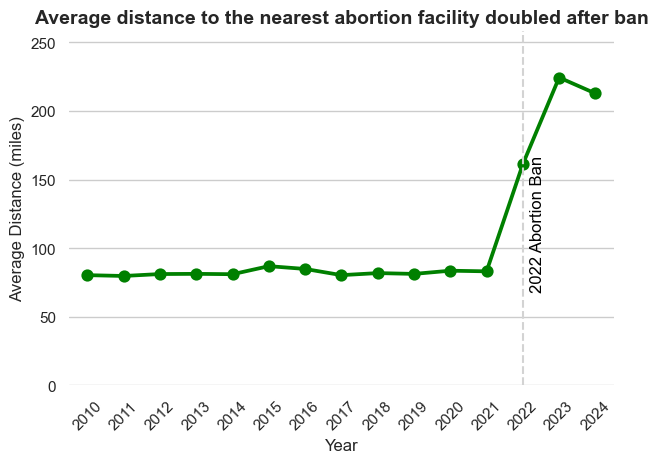

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Set theme
sns.set_theme(style="whitegrid", palette="pastel")

# Ensure year is string so x-axis shows actual years
births_merged['year'] = births_merged['year'].astype(str)

# Aggregate mean distance by year
grouped = births_merged.groupby("year")["dist_mean"].mean().reset_index()

# Create the point plot
g = sns.pointplot(
    data=grouped,
    x="year",
    y="dist_mean",
    color="green",
    marker="o",
    linestyles="-"
)

# Expand y-axis and start at 0
ymax = grouped["dist_mean"].max()
g.set_ylim(0, ymax * 1.15)  # 15% headroom

# Title
g.set_title("Average distance to the nearest abortion facility doubled after ban", fontsize=14, weight='bold')

# Axis labels
g.set_xlabel("Year", fontsize=12)
g.set_ylabel("Average Distance (miles)", fontsize=12)

# Rotate x-ticks so years are readable
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# Add vertical line for 2022 abortion ban
plt.axvline(x=grouped[grouped['year']=="2022"].index[0], linestyle='--', color='lightgrey', linewidth=1.5)
g.text(
    grouped[grouped['year']=="2022"].index[0] + 0.2,
    ymax * 0.75,
    "2022 Abortion Ban",
    rotation=90,
    color='black',
    va='top',
    ha='left'
)

# Format y-axis with commas
g.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Remove top/right spines for cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [23]:
county_year = (
    births_df
    .groupby(["year", "county"], as_index=False)
    .agg({
        "births": "sum",
        "population": "sum"
    })
)
county_year["birth_rate"] = (county_year["births"] / county_year["population"]) * 1000
county_year["county"] = county_year["county"].str.strip().str.lower()
dist_year["county"]    = dist_year["county"].str.strip().str.lower()
final_df = county_year.merge(
    dist_year[["year", "county", "dist_mean", "origin_fips_code"]],
    on=["year", "county"],
    how="left"
)

final_df["post_ban"] = (final_df["year"] >= 2022).astype(int)

final_df

,year,county,births,population,birth_rate,dist_mean,origin_fips_code,post_ban
0,2010,adair,368.0,22759.0,16.169427,41.352927,40001,0
1,2010,alfalfa,42.0,5377.0,7.811047,117.173210,40003,0
2,2010,atoka,167.0,14153.0,11.799618,116.996120,40005,0
3,2010,beaver,63.0,5414.0,11.636498,230.243500,40007,0
4,2010,beckham,326.0,22054.0,14.781899,122.553670,40009,0
...,...,...,...,...,...,...,...,...
1150,2024,wagoner,929.0,91257.0,10.180041,179.042720,40145,1
1151,2024,washington,580.0,54016.0,10.737559,130.514463,40147,1
1152,2024,washita,115.0,10758.0,10.689719,264.817230,40149,1
1153,2024,woods,59.0,8291.0,7.116150,138.861540,40151,1


In [24]:
import statsmodels.formula.api as smf

reg_df = final_df.dropna(subset=["birth_rate", "dist_mean"]).copy()
reg_df["post_ban"] = (reg_df["year"] >= 2022).astype("int64")
reg_df["year_cat"] = reg_df["year"].astype(str)
reg_df["dist_mean"] = reg_df["dist_mean"].astype("float64")
reg_df["birth_rate"] = reg_df["birth_rate"].astype("float64")


In [25]:
reg_df

,year,county,births,population,birth_rate,dist_mean,origin_fips_code,post_ban,year_cat
0,2010,adair,368.0,22759.0,16.169427,41.352927,40001,0,2010
1,2010,alfalfa,42.0,5377.0,7.811047,117.173210,40003,0,2010
2,2010,atoka,167.0,14153.0,11.799618,116.996120,40005,0,2010
3,2010,beaver,63.0,5414.0,11.636498,230.243500,40007,0,2010
4,2010,beckham,326.0,22054.0,14.781899,122.553670,40009,0,2010
...,...,...,...,...,...,...,...,...,...
1150,2024,wagoner,929.0,91257.0,10.180041,179.042720,40145,1,2024
1151,2024,washington,580.0,54016.0,10.737559,130.514463,40147,1,2024
1152,2024,washita,115.0,10758.0,10.689719,264.817230,40149,1,2024
1153,2024,woods,59.0,8291.0,7.116150,138.861540,40151,1,2024


In [26]:
model_pp = smf.ols(
    "birth_rate ~ dist_mean * post_ban",
    data=reg_df
).fit(cov_type="HC3")

print(model_pp.summary())


                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     24.43
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           2.51e-15
Time:                        01:29:34   Log-Likelihood:                -2373.8
No. Observations:                1155   AIC:                             4756.
Df Residuals:                    1151   BIC:                             4776.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.9790      0

In [27]:
import statsmodels.formula.api as smf

reg_df = final_df.dropna(subset=["birth_rate"]).copy()

reg_df["post_ban"] = (reg_df["year"] >= 2022).astype(int)

model_simple = smf.ols(
    formula="birth_rate ~ post_ban",
    data=reg_df
).fit(cov_type="HC3")

print(model_simple.summary())


                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     59.76
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           2.32e-14
Time:                        01:29:34   Log-Likelihood:                -2377.8
No. Observations:                1155   AIC:                             4760.
Df Residuals:                    1153   BIC:                             4770.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0634      0.064    188.304      0.0

In [28]:
missing_in_dist = (
    births_df[["year", "county"]]
    .drop_duplicates()
    .merge(dist_year[["year", "county"]], on=["year", "county"], how="left", indicator=True)
)

missing_in_dist[missing_in_dist["_merge"] == "left_only"]


,year,county,_merge


In [29]:
births_merged_cleaned = births_merged[~births_merged['race'].isin(['Unknown', 'Other'])]

reg_df = births_merged_cleaned.dropna(subset=["birth_rate", "dist_mean"]).copy()
reg_df["post_ban"] = (reg_df["year"] >= 2022).astype("int64")
reg_df["year_cat"] = reg_df["year"].astype(str)
reg_df["dist_mean"] = reg_df["dist_mean"].astype("float64")
reg_df["birth_rate"] = reg_df["birth_rate"].astype("float64")

reg_df['race'] = reg_df['race'].astype('category')
reg_df['race'] = reg_df['race'].cat.reorder_categories(
    ['White', 'Black or African American', 'Asian', 'American Indian or Alaska Native', 'More than one race', 'Native Hawaiian or Other Pacific Islander'],  # put your desired baseline first
    ordered=False
)

formula = "birth_rate ~ dist_mean * post_ban * race + C(county) + C(year_cat)"

model_fe_race = smf.ols(
    formula=formula,
    data=reg_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": reg_df["county"]}
)

print(model_fe_race.summary())

TypeError: '>=' not supported between instances of 'str' and 'int'

In [30]:
births_by_age = pd.read_csv("../data/output/oklahoma_births-by-county_by-age_2010-2024.csv")

births_by_age['county'] = births_by_age['county'].str.lower()
births_by_age_merged = births_by_age.merge(
    dist_year[["year", "county", "dist_mean"]],
    on=["year", "county"],
    how="left"
)
births_by_age_merged = births_by_age_merged[births_by_age_merged['county'] != 'unknown']

In [31]:
births_by_age_merged = births_by_age_merged[~births_by_age_merged['age'].isin(['Unknown Age'])]

reg_df = births_by_age_merged.dropna(subset=["birth_rate", "dist_mean"]).copy()
reg_df["post_ban"] = (reg_df["year"] >= 2022).astype("int64")
reg_df["year_cat"] = reg_df["year"].astype(str)
reg_df["dist_mean"] = reg_df["dist_mean"].astype("float64")
reg_df["birth_rate"] = reg_df["birth_rate"].astype("float64")

reg_df['age'] = reg_df['age'].astype('category')
reg_df['age'] = reg_df['age'].cat.reorder_categories(
    ['25-29 years', '10-14 years','15-17 years', '18-19 years', 
      '20-24 years', '30-34 years', '35-39 years', '40-44 years', '45-54 years',
    ],  # put your desired baseline first
    ordered=False
)

formula = "birth_rate ~ dist_mean * post_ban * age + C(county) + C(year_cat)"

model_fe_age = smf.ols(
    formula=formula,
    data=reg_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": reg_df["county"]}
)

print(model_fe_age.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.422e+05
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          2.22e-172
Time:                        01:29:44   Log-Likelihood:                -32346.
No. Observations:                8384   AIC:                         6.494e+04
Df Residuals:                    8259   BIC:                         6.582e+04
Df Model:                         124                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 125, but rank is 48
  warnings.warn('covariance of constraints does not have full '


In [ ]:
births_by_edu = pd.read_csv('../data/output/oklahoma_births_by-mothers-edu_w-pop_2010-2024.csv')
births_by_edu['county'] = births_by_edu['county'].str.lower()
births_by_edu_merged = births_by_edu.merge(
    dist_year[["year", "county", "dist_mean"]],
    on=["year", "county"],
    how="left"
)
births_by_edu_merged = births_by_edu_merged[births_by_edu_merged['county'] != 'unknown']

In [ ]:
births_by_edu_merged = births_by_edu_merged[~births_by_edu_merged['education'].isin(['UNKNOWN'])]

reg_df = births_by_edu_merged.dropna(subset=["live_births_per_1000"]).reset_index().copy()
reg_df["post_ban"] = (reg_df["year"] >= 2022).astype("int64")
reg_df["year_cat"] = reg_df["year"].astype(str)
reg_df["live_births_per_1000"] = reg_df["live_births_per_1000"].astype("float64")

reg_df['education'] = reg_df['education'].astype('category')
reg_df['education'] = reg_df['education'].cat.reorder_categories(
    ['>= 16 years', '0 - 8 years', '12 years',  '9 - 11 years', '13 - 15 years'],  # put your desired baseline first
    ordered=False
)

formula = "live_births_per_1000 ~ dist_mean * post_ban * education + C(county) + C(year_cat)"

model_fe_edu = smf.ols(
    formula=formula,
    data=reg_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": reg_df["county"]}
)

print(model_fe_edu.summary())

                             OLS Regression Results                             
Dep. Variable:     live_births_per_1000   R-squared:                       0.614
Model:                              OLS   Adj. R-squared:                  0.606
Method:                   Least Squares   F-statistic:                     2838.
Date:                  Wed, 03 Dec 2025   Prob (F-statistic):          6.89e-105
Time:                          22:49:58   Log-Likelihood:                -19154.
No. Observations:                  5775   AIC:                         3.853e+04
Df Residuals:                      5666   BIC:                         3.925e+04
Df Model:                           108                                         
Covariance Type:                cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 109, but rank is 32
  warnings.warn('covariance of constraints does not have full '


In [ ]:
births_rural = pd.read_csv('../data/output/oklahoma_rural_births_by-county_2010-2024.csv')
births_rural = births_rural[(births_rural['county'].notnull()) & (births_rural['county'] != 'UNKNOWN')]
# fixing weird glitch
births_rural = births_rural[births_rural['population'] != 0]
births_rural['region_type'] = 'rural'
births_metro_micro = pd.read_csv('../data/output/oklahoma_metro-micro_births_by-county_2010-2024.csv')
births_metro_micro = births_metro_micro[(births_metro_micro['county'].notnull()) & (births_metro_micro['county'] != 'UNKNOWN')]
# fixing weird glitch
births_metro_micro = births_metro_micro[births_metro_micro['population'] != 0]
births_metro_micro['region_type'] = 'metro/micro'
# merge into final dataset
births_by_region_type = pd.concat([births_metro_micro,births_rural])

births_by_region_type['county'] = births_by_region_type['county'].str.lower()
births_by_region_merged = births_by_region_type.merge(
    dist_year[["year", "county", "dist_mean"]],
    on=["year", "county"],
    how="left"
)
births_by_region_merged = births_by_region_merged[births_by_region_merged['county'] != 'unknown']


In [ ]:
births_by_region_merged[['dist_mean','region_type']].groupby('region_type').mean()

,dist_mean
region_type,
metro/micro,91.078675
rural,131.498496


In [ ]:
reg_df = births_by_region_merged.dropna(subset=["birth_rate"]).reset_index().copy()
reg_df["post_ban"] = (reg_df["year"] >= 2022).astype("int64")
reg_df["year_cat"] = reg_df["year"].astype(str)
reg_df["birth_rate"] = reg_df["birth_rate"].astype("float64")

reg_df['region_type'] = reg_df['region_type'].astype('category')

formula = "birth_rate ~ dist_mean * post_ban * region_type + C(county) + C(year_cat)"

model_fe_region = smf.ols(
    formula=formula,
    data=reg_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": reg_df["county"]}
)

print(model_fe_region.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1948.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           4.11e-94
Time:                        23:53:47   Log-Likelihood:                -1674.2
No. Observations:                1155   AIC:                             3540.
Df Residuals:                    1059   BIC:                             4025.
Df Model:                          95                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 97, but rank is 19
  warnings.warn('covariance of constraints does not have full '


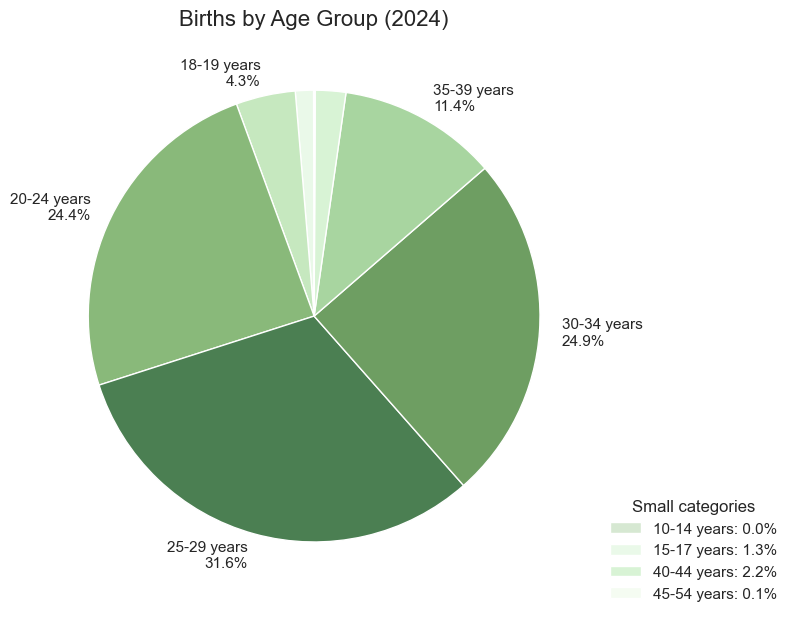

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

year_to_plot = 2024
df_year = births_by_age_merged[births_by_age_merged['year'] == year_to_plot].copy()

births_by_age = df_year.groupby('age', as_index=False)['births'].sum()
total_births = births_by_age['births'].sum()
births_by_age['percent'] = births_by_age['births'] / total_births

ordered_age = [
    '10-14 years', '15-17 years', '18-19 years',
    '20-24 years', '25-29 years', '30-34 years',
    '35-39 years', '40-44 years', '45-54 years'
]
births_by_age['age'] = pd.Categorical(
    births_by_age['age'],
    categories=ordered_age,
    ordered=True
)
births_by_age = births_by_age.sort_values('age').reset_index(drop=True)

sizes = births_by_age['percent'].values
ages  = births_by_age['age'].astype(str).values

# ---- green palette (same as before) ----
greens = [
    "#4B7F52", "#6E9E62", "#89B97A", "#A8D5A0",
    "#C6E8BF", "#D8F3D5", "#EAF9E9", "#F5FCF2", "#D6E8D2"
]

sorted_by_size = births_by_age.sort_values('percent', ascending=False).reset_index(drop=True)
sorted_by_size['color'] = greens[:len(sorted_by_size)] 

color_map = dict(zip(sorted_by_size['age'], sorted_by_size['color']))
colors = births_by_age['age'].map(color_map).values

fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_alpha(0.0)
ax.set_facecolor("none")

# label only slices >= 3%
labels = [
    f"{a}\n{p*100:.1f}%"
    if p >= 0.03 else ""
    for a, p in zip(ages, sizes)
]

wedges, _ = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
)

ax.set_title("Births by Age Group (2024)", fontsize=16)

small = births_by_age[births_by_age['percent'] < 0.03]

legend_labels = [
    f"{row['age']}: {row['percent']*100:.1f}%"
    for _, row in small.iterrows()
]
legend_handles = [wedges[i] for i in small.index]  

ax.legend(
    legend_handles,
    legend_labels,
    title="Small categories",
    loc="upper left",
    bbox_to_anchor=(1, 0.2),
    frameon=False
)

plt.tight_layout()

plt.savefig(
    "births_by_age_2024.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight"
)

plt.show()


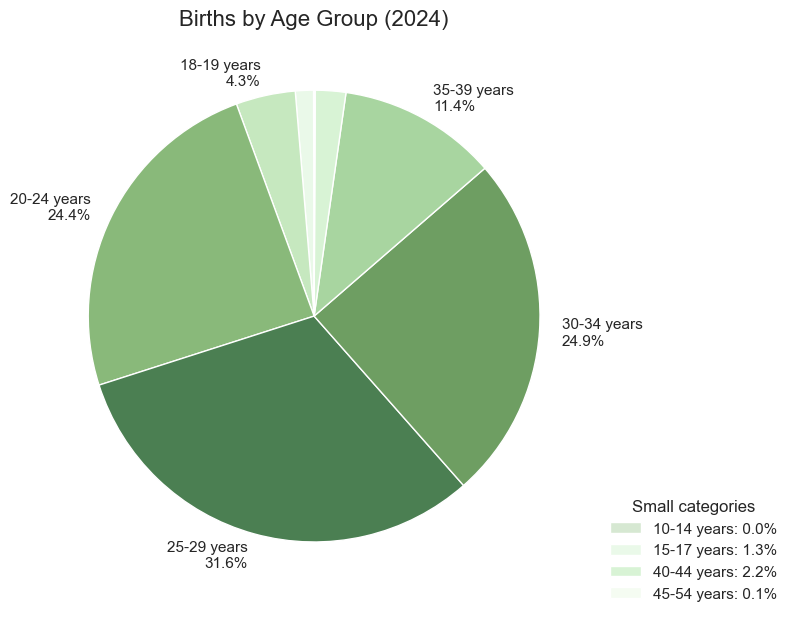

In [34]:
year_to_plot = 2024
df_year = births_by_age_merged[births_by_age_merged['year'] == year_to_plot].copy()

births_by_age = df_year.groupby('age', as_index=False)['births'].sum()
total_births = births_by_age['births'].sum()
births_by_age['percent'] = births_by_age['births'] / total_births

ordered_age = [
    '10-14 years', '15-17 years', '18-19 years',
    '20-24 years', '25-29 years', '30-34 years',
    '35-39 years', '40-44 years', '45-54 years'
]
births_by_age['age'] = pd.Categorical(births_by_age['age'], categories=ordered_age, ordered=True)
births_by_age = births_by_age.sort_values('age').reset_index(drop=True)

sizes = births_by_age['percent'].values
ages  = births_by_age['age'].astype(str).values

greens = [
    "#4B7F52", "#6E9E62", "#89B97A", "#A8D5A0",
    "#C6E8BF", "#D8F3D5", "#EAF9E9", "#F5FCF2", "#D6E8D2"
]

sorted_by_size = births_by_age.sort_values('percent', ascending=False).reset_index(drop=True)
sorted_by_size['color'] = greens[:len(sorted_by_size)]
color_map = dict(zip(sorted_by_size['age'], sorted_by_size['color']))
colors = births_by_age['age'].map(color_map).values

fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_alpha(0.0)
ax.set_facecolor("none")

labels = [
    f"{a}\n{p*100:.1f}%"
    if p >= 0.03 else ""
    for a, p in zip(ages, sizes)
]

wedges, _ = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

ax.set_title("Births by Age Group (2024)", fontsize=16)

small = births_by_age[births_by_age['percent'] < 0.03]

legend_labels = [
    f"{row['age']}: {row['percent']*100:.1f}%"
    for _, row in small.iterrows()
]

legend_handles = [wedges[i] for i in small.index]

ax.legend(
    legend_handles,
    legend_labels,
    title="Small categories",
    loc="upper left",
    bbox_to_anchor=(1, 0.2),
    frameon=False
)

plt.tight_layout()

plt.savefig(
    "births_by_age_2024.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight"
)

plt.show()
